In [1]:
from pathlib import Path
import sqlite3
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from scipy.stats import gaussian_kde

/home/mafalda/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# path to arrayrgbase
print("We will use the Database 1, named HumanA_Exp1.") 
db_path = Path('/home/mafalda/Desktop/DataBases/HumanA_Exp1.db')

# connect to arrayrgbase
connection = sqlite3.connect(db_path)
cr = connection.cursor()

We will use the Database 1, named HumanA_Exp1.


In [3]:
# get the node number and coordinates of a specific trial
def get_nodes_and_coordinates_trial(n, b):
    sql_instruction = """
        SELECT dp.node, gc.nodeCentroid_x, gc.nodeCentroid_z
        FROM trials t
        JOIN graph_coordinates gc ON dp.node = gc.nodeNr
        JOIN dataPoints_reduced dp on dp.TrialId = t.Id
        WHERE t.participantId = """ + str(n) + """ AND dp.validDatapoint = 'VALID' AND dp.AdditionalInfo = 'FirstDPofNode' AND sessionNr = """ + str(b) + """
        ORDER BY dp.timeStampDataPointStart ASC
        """
    cr.execute(sql_instruction)
    nodes_and_coordinates = cr.fetchall()
    
    # remove consecutive duplicates from list 
    nodes_coor = [nodes_and_coordinates[0]]
    for i in range(1, len(nodes_and_coordinates)):
        if nodes_and_coordinates[i] != nodes_and_coordinates[i - 1]:
            nodes_coor.append(nodes_and_coordinates[i])
    
    # sperate the values of nodes, X and Y coordinates
    nodes = []
    coor_x = []
    coor_y = []
    for node, x, z in nodes_coor:
        nodes.append(node)
        coor_x.append(x)
        coor_y.append(z)
    
    return nodes, coor_x, coor_y

In [4]:
#  number of total trials in the database
def get_num_trials():
    sql_instruction = """SELECT distinct t.participantId
        FROM trials t
        WHERE t.validParticipant = 'VALID'
        ORDER BY participantId asc
        """
    cr.execute(sql_instruction)
    num = cr.fetchall()
    # get only the number 
    num1 = [tup[0] for tup in num]
    return num1

num_trials = get_num_trials()

for i in num_trials:
    for b in range(1,6):
        # get the nodes, X and Y coordinates of the trial
        nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(i, b)

In [5]:
# calculate the gyration of gyration using the variables N, ni ri and rcm

"""
i = x,y corrdinates of the location
-> coordinates list
N = total number of visits or time spent
-> length of nodes list
rcm = mean(x) mean(y) [center of mass]
-> coordinates lists
ri = vector of coordinates
-> coordinates lists
ni = visitation frequency or total time spent in location i
-> count how many times they were at each node
"""
# calculate the gyration of gyration using the variables N, ni ri and rcm
def calculate_rg(N, ni, ri, rcm):
    results = []
    # for every value of ri
    for i in range(len(ri)):
        substr = tuple(np.subtract(ri[i], rcm))
        skalar = sum(np.square(substr))
        multi = ni[i] * skalar
        results.append(multi)
    # sum up everything
    all = sum(results)
    # divide by N
    divi = all/N
    # square root of the sum
    final = np.sqrt(divi)
    return final

In [6]:
# N = total number of visits
# therefore, N is the length of all visited nodes
def get_length (list):
    l = len(list)
    return l

In [7]:
# ri = vector of coordinates
# therefore, ri is a vector of the coordinates X and Y of a specific trial a
def get_vector(a, b):
    sql = """SELECT gc.nodeCentroid_x, gc.nodeCentroid_z
        FROM trials t
        JOIN graph_coordinates gc ON dp.node = gc.nodeNr
        JOIN dataPoints_reduced dp on dp.TrialId = t.Id
        WHERE t.participantId = """ + str(a) + """ AND dp.validDatapoint = 'VALID' AND dp.AdditionalInfo = 'FirstDPofNode' AND sessionNr = """ + str(b) + """
        ORDER BY dp.timeStampDataPointStart ASC
        """
    cr.execute(sql)
    vectors = cr.fetchall()
    ri = [vectors[0]]
    # delete consecutive duplicates
    for i in range(1, len(vectors)):
        if vectors[i] != vectors[i - 1]:
            ri.append(vectors[i])
    return ri


In [8]:
# rcm = center of mass
# mean(x), mean(y)
def rcm(X, Y):
    rcm = (np.mean(X), np.mean(Y))
    return rcm


In [9]:
# ni = visitation frequency of node n
# how often is a node in the list?
def calc_ni(node_nr, list):
    frequency = 0
    for i in list:
        if i == node_nr:
            frequency = frequency + 1
    return frequency

# for every node in the visisted nodes, calculate the visitation frequency
def ni_c(nodes):
    ni = []
    for i in nodes:
        ni.append(calc_ni(i, nodes))
    return ni

In [10]:
# remove consecutive duplicates of a zipped list
def remove_consecutive_duplicates(zipped_list):
    unique_list = [zipped_list[0]]  # Include the first element
    for i in range(1, len(zipped_list)):
        if zipped_list[i] != zipped_list[i - 1]:
            unique_list.append(zipped_list[i])
    return unique_list


# Lk is the kth most frequented location
# Combine the lists into a list of tuples
def sorted_vis(ni, ri, nodes, X, Y):
    combined = list(zip(ni, ri, nodes, X, Y))
    # Sort the combined list based on the values of ri in descending order
    sorted_combined = sorted(combined, key = lambda x: x[0], reverse=True)
    # delete duplicates
    sorted_1 = remove_consecutive_duplicates(sorted_combined)
    # Unpack the sorted tuples back into separate lists
    ni_sorted, ri_sorted, nodes_sorted, x_sorted, y_sorted = zip(*sorted_1)
    return ni_sorted, ri_sorted, nodes_sorted, x_sorted, y_sorted


In [11]:
'''
Lk is the kth most frequented location
Nk is the sum of the weights assigned to the kth most frequented locations
rgk represent the mobility range restricted to the kth most frequented locations

IF rgk(2) ~= rg, then the characteristic travelled distance is dominated by the two most frequented locations
'''
# use the sorted list to get the values until k
# and use the radius of gyration formulas to calculate rgk
def k_th (k, ni_sorted, ri_sorted, x_sorted, y_sorted):
    Nk = k
    nik = ni_sorted[:Nk]
    rik = ri_sorted[:Nk]
    rcmk = (np.mean(x_sorted[:Nk]), np.mean(y_sorted[:Nk]))
    # print("RCM: " + str(rcmk))
    resk = calculate_rg(Nk, nik, rik, rcmk)
    return resk

In [12]:
#  number of total participants in the database
def get_num_trials():
    sql_instruction = """SELECT distinct t.participantId
        FROM trials t
        WHERE t.validParticipant = 'VALID'
        ORDER BY participantId asc
        """
    cr.execute(sql_instruction)
    num = cr.fetchall()
    # get only the number 
    num1 = [tup[0] for tup in num]
    return num1

In [13]:
rg = {}  # Dictionary to store rg values for each trial
rgk = {}  # Dictionary to store rgk values for each trial

Rg1 = [] #a list with all values
Rgk = []
participants = []
session = []

num_trials = get_num_trials()


for i in num_trials:
    for b in range(1,6):
        # get the nodes, X and Y coordinates of the trial
        nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(i, b)
        # Optional: Print some summary of nodes
        # print(f"Participant {i}, Session {b}: Number of nodes: {len(nodes)}, Mean X: {np.mean(coor_x)}, Mean Y: {np.mean(coor_y)}")
        # get the values for rg 
        N = get_length(nodes)
        ri = get_vector(i, b)
        rcm = (np.mean(coor_x), np.mean(coor_y))
        ni = ni_c(nodes)
        # calculate rg for the trial and store it in rg dictionary
        rg[i] = calculate_rg(N, ni, ri, rcm)
        # calculate rg for the trial and store it in the rg list
        Rg1.append(calculate_rg(N, ni, ri, rcm))
        # calculate rgk for the trial and store it in rgk dictionary
        ni_sorted, ri_sorted, nodes_sorted, X_sorted, Y_sorted = sorted_vis(ni, ri, nodes, coor_x, coor_y)
        #rgk_values = []
        rgk_values = [k_th(k, ni_sorted, ri_sorted, X_sorted, Y_sorted) for k in range(1, 11)]
        Rgk.append(rgk_values)
        participants.append(i)
        session.append(b)
        print(i)  # Print just to indicate progress

365
365
365
365
365
1754
1754
1754
1754
1754
2258
2258
2258
2258
2258
2693
2693
2693
2693
2693
3310
3310
3310
3310
3310
4176
4176
4176
4176
4176
4597
4597
4597
4597
4597
4796
4796
4796
4796
4796
4917
4917
4917
4917
4917
5238
5238
5238
5238
5238
5741
5741
5741
5741
5741
6642
6642
6642
6642
6642
7093
7093
7093
7093
7093
7412
7412
7412
7412
7412
7842
7842
7842
7842
7842
8007
8007
8007
8007
8007
8469
8469
8469
8469
8469
8673
8673
8673
8673
8673
8695
8695
8695
8695
8695
9472
9472
9472
9472
9472
9502
9502
9502
9502
9502
9586
9586
9586
9586
9586
9601
9601
9601
9601
9601


In [14]:
first_elements = [sublist[0] for sublist in Rgk]
print(first_elements)

second_elements = [sublist[1] for sublist in Rgk]
print(second_elements)

third_elements = [sublist[2] for sublist in Rgk]
print(third_elements)

fourth_elements = [sublist[3] for sublist in Rgk]
print(fourth_elements)

fifth_elements = [sublist[4] for sublist in Rgk]
print(fifth_elements)

sixth_elements = [sublist[5] for sublist in Rgk]
print(sixth_elements)

seventh_elements = [sublist[6] for sublist in Rgk]
print(seventh_elements)

eight_elements = [sublist[7] for sublist in Rgk]
print(eight_elements)

ninth_elements = [sublist[8] for sublist in Rgk]
print(ninth_elements)

tenth_elements = [sublist[9] for sublist in Rgk]
print(tenth_elements)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[53.628205032426735, 5.86770824087224, 66.09326743322652, 70.89428088710683, 25.153837789799677, 101.1805317242403, 6.080193253507654, 7.862203006226133, 107.6540187596452, 11.834506984051192, 25.439334154458944, 6.564005469258341, 12.894887552824963, 13.231381048267243, 59.84624744571149, 6.2277381305111295, 7.298373980216549, 3.5300053116107346, 17.40869035855371, 6.324555320336759, 4.298336241436269, 25.63027994384767

In [15]:
import csv

sessions = []

# Create a DataFrame from the lists
df = pd.DataFrame({'IDs': participants, 'session': session, 'Rg': Rg1, 'k=2': second_elements, 'k=3': third_elements, 'k=4': fourth_elements, 'k=5': fifth_elements, 'k=6': sixth_elements, 'k=7': seventh_elements,
                   'k=8': eight_elements, 'k=9': ninth_elements, 'k=10': tenth_elements})

In [16]:
connection.close()

In [17]:
# path to arrayrgbase
print("We will use the Database 1, named HumanA_Exp2.") 
db_path = Path('/home/mafalda/Desktop/DataBases/HumanA_Exp2.db')

# connect to arrayrgbase
connection = sqlite3.connect(db_path)
cr = connection.cursor()

We will use the Database 1, named HumanA_Exp2.


In [18]:
rg = {}  # Dictionary to store rg values for each trial
rgk = {}  # Dictionary to store rgk values for each trial

Rg1 = [] #a list with all values
Rgk = []
participants = []
session = []

num_trials = get_num_trials()

for i in num_trials:
    for b in range(1,6):
        # get the nodes, X and Y coordinates of the trial
        nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(i, b)
        # get the values for rg 
        N = get_length(nodes)
        ri = get_vector(i, b)
        rcm = (np.mean(coor_x), np.mean(coor_y))
        ni = ni_c(nodes)
        # calculate rg for the trial and store it in rg dictionary
        rg[i] = calculate_rg(N, ni, ri, rcm)
        # calculate rg for the trial and store it in the rg list
        Rg1.append(calculate_rg(N, ni, ri, rcm))
        # calculate rgk for the trial and store it in rgk dictionary
        ni_sorted, ri_sorted, nodes_sorted, X_sorted, Y_sorted = sorted_vis(ni, ri, nodes, coor_x, coor_y)
        #rgk_values = []
        rgk_values = [k_th(k, ni_sorted, ri_sorted, X_sorted, Y_sorted) for k in range(1, 11)]
        Rgk.append(rgk_values)
        participants.append(i)
        session.append(b)
        print(i)  # Print just to indicate progress


1031
1031
1031
1031
1031
1268
1268
1268
1268
1268
1574
1574
1574
1574
1574
1843
1843
1843
1843
1843
4580
4580
4580
4580
4580
4598
4598
4598
4598
4598
4847
4847
4847
4847
4847
4875
4875
4875
4875
4875
5161
5161
5161
5161
5161
5189
5189
5189
5189
5189
5743
5743
5743
5743
5743
5766
5766
5766
5766
5766
5851
5851
5851
5851
5851
5972
5972
5972
5972
5972
6406
6406
6406
6406
6406
7081
7081
7081
7081
7081
7823
7823
7823
7823
7823
7935
7935
7935
7935
7935
8629
8629
8629
8629
8629
9297
9297
9297
9297
9297
9627
9627
9627
9627
9627


In [19]:
first_elements = [sublist[0] for sublist in Rgk]
print(first_elements)

second_elements = [sublist[1] for sublist in Rgk]
print(second_elements)

third_elements = [sublist[2] for sublist in Rgk]
print(third_elements)

fourth_elements = [sublist[3] for sublist in Rgk]
print(fourth_elements)

fifth_elements = [sublist[4] for sublist in Rgk]
print(fifth_elements)

sixth_elements = [sublist[5] for sublist in Rgk]
print(sixth_elements)

seventh_elements = [sublist[6] for sublist in Rgk]
print(seventh_elements)

eight_elements = [sublist[7] for sublist in Rgk]
print(eight_elements)

ninth_elements = [sublist[8] for sublist in Rgk]
print(ninth_elements)

tenth_elements = [sublist[9] for sublist in Rgk]
print(tenth_elements)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[31.510690425808054, 38.59255649301647, 77.60270613838154, 38.74299891951808, 4.204412364805958, 11.834506984051192, 21.78386252863954, 8.04145077430408, 15.086095511356783, 81.27288139348819, 69.75110927360195, 58.63197364351072, 19.885854827545668, 37.341017159418676, 3.1180478223116, 25.75802331907716, 3.9745282738961616, 77.84702948732212, 82.3081342775668, 57.27454939095121, 31.412356026110334, 7.089083300456859, 25.34421024722523, 15.211472278806156, 19.5209556203

In [20]:
new_df = pd.DataFrame({'IDs': participants, 'session': session, 'Rg': Rg1, 'k=2': second_elements, 'k=3': third_elements, 'k=4': fourth_elements, 'k=5': fifth_elements, 'k=6': sixth_elements, 'k=7': seventh_elements,
                   'k=8': eight_elements, 'k=9': ninth_elements, 'k=10': tenth_elements})

# Append the new data to the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Write the updated DataFrame to a CSV file
df.to_csv('data_both.csv', index=False)


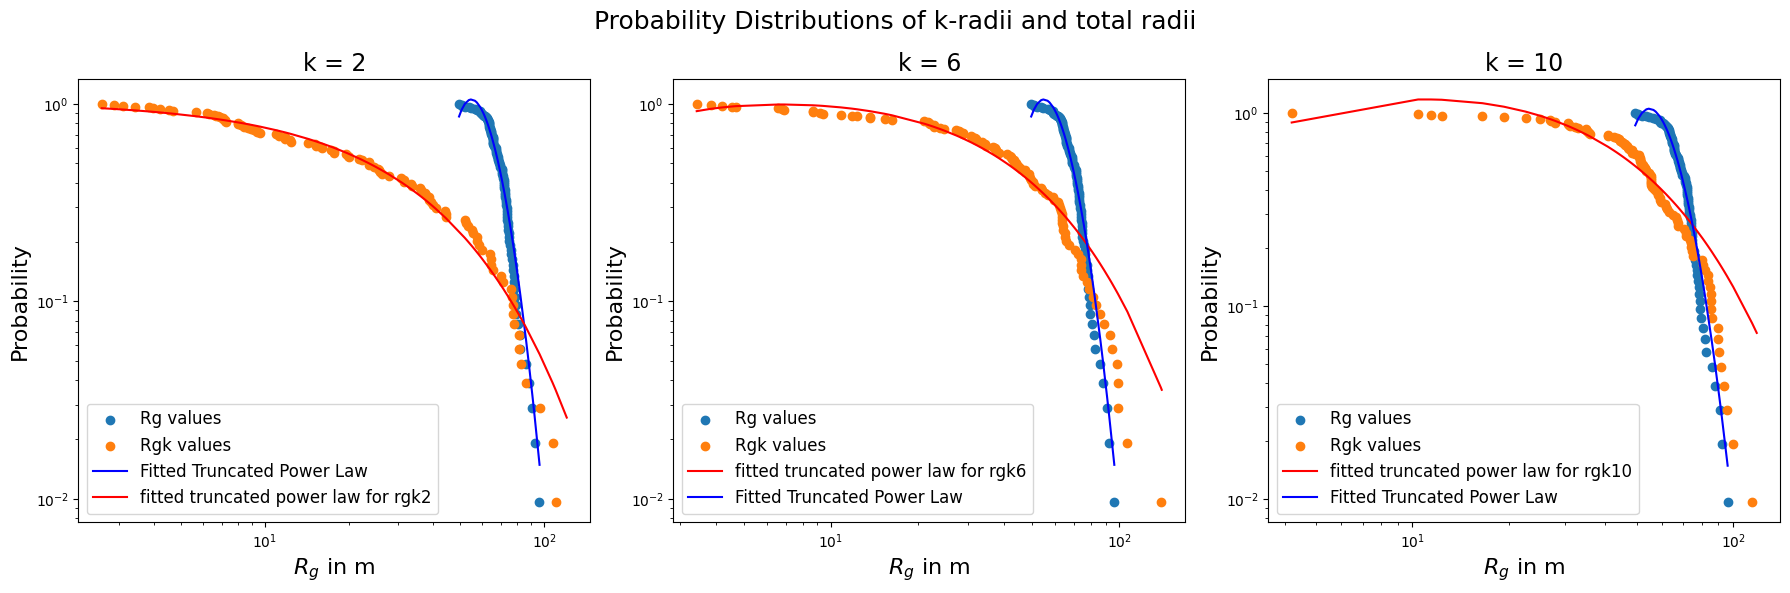

Fitted Parameters:
 r0 = -36.038162055749716
 a = -4.098075176037627
 rcut = 4.5815803294337725


In [21]:
from scipy.optimize import curve_fit

arrayrg = np.array(sorted(Rg1), dtype=np.float64)
arrayrgk2 = np.array(sorted(second_elements), dtype=np.float64)
arrayrgk6 = np.array(sorted(sixth_elements), dtype=np.float64)
arrayrgk10 = np.array(sorted(tenth_elements), dtype=np.float64)


# Truncated Power Law Function
def truncated_power_law(Rg, r0, a, rcut):
    return (Rg + r0)**(-a) * np.exp(-Rg / rcut) 


initial_guesses = [59.566962989424855, 3.5263927061728717, 50.627239926990367]

# Example: Using the Trust Region Reflective algorithm

params10, covariance10 = curve_fit(truncated_power_law, arrayrgk10, np.linspace(1, 0, num=len(arrayrgk10)), maxfev = 10000, method='trf')

params, covariance = curve_fit(truncated_power_law, arrayrg, np.linspace(1, 0, num=len(arrayrg)), p0=initial_guesses, maxfev = 10000, method='trf')
params6, covariance6 = curve_fit(truncated_power_law, arrayrgk6, np.linspace(1, 0, num=len(arrayrgk6)), maxfev = 10000, method='trf')
params2, covariance2 = curve_fit(truncated_power_law, arrayrgk2, np.linspace(1, 0, num=len(arrayrgk2)), maxfev = 10000, method='trf')


# Parameters

r02, a2, rcut2 = params2
r06, a6, rcut6 = params6
r0, a, rcut = params
r010, a10, rcut10 = params10



# Plotting the original data and the fitted curve
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk2, np.linspace(1, 0, num=len(arrayrgk2)), label='Rgk values')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.plot(arrayrgk2, truncated_power_law(arrayrgk2, *params2), color = 'red', label='fitted truncated power law for rgk2')
plt.xlabel('$R_g$ in m', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)
plt.title('k = 2', fontsize = 17)
plt.legend(fontsize = 12)
plt.xscale('log')
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk6, np.linspace(1, 0, num=len(arrayrgk6)), label='Rgk values')
plt.plot(arrayrgk6, truncated_power_law(arrayrgk6, *params6), color = 'red', label='fitted truncated power law for rgk6')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.xlabel('$R_g$ in m', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)
plt.title('k = 6', fontsize = 17)
plt.legend(fontsize = 12)
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,3,3)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk10, np.linspace(1, 0, num=len(arrayrgk10)), label='Rgk values')
plt.plot(arrayrgk10, truncated_power_law(arrayrgk10, *params10), color = 'red', label='fitted truncated power law for rgk10')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.xlabel('$R_g$ in m', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)
plt.title('k = 10', fontsize = 17)
plt.legend(fontsize = 12)
plt.xscale('log')
plt.yscale('log')

# Add a single title for all plots
plt.suptitle('Probability Distributions of k-radii and total radii', fontsize = 18)

plt.tight_layout()
plt.show()

# Print the fitted parameters
print(f"Fitted Parameters:\n r0 = {r0}\n a = {a}\n rcut = {rcut}")

In [22]:

x_data = np.array([34.36675296, 36.8910677,38.45803644, 41.28443461, 43.06663745, 48.04838922,
 48.98085469, 49.17804585, 50.72596458, 51.33515179, 51.92983326, 52.54397764,
 52.98767057, 53.43180601, 53.44661181, 53.74279414, 53.97077625, 57.46866624,
 57.84482098, 57.98542493, 58.28764762, 59.54494351, 59.78206987, 59.82829939,
 59.98850476, 60.2418673 , 60.71691946, 61.02592458, 61.4797954,  62.01153469,
 62.45346612, 62.81540395, 62.90727599, 63.16872941, 63.20017203, 63.24941018,
 63.6391498,  63.93990211, 63.98962457, 64.20204973, 64.83805225, 64.86483663,
 64.92575989, 65.03959782, 65.56800817, 65.63042761, 65.6398844 , 65.67894441,
 66.18115232, 66.8876521 , 67.61241591, 67.6643572 , 67.87994267, 67.99394371,
 67.99796398, 68.32961189, 68.35715153, 68.36238736, 68.50366469, 68.69519274,
 69.18979201, 69.24721705, 69.50372681, 69.69677754, 69.70040532, 70.02011886,
 70.20006465, 70.48519379, 70.523709,   70.71281015, 70.97790195, 71.20728096,
 71.29564061, 71.53247674, 71.90206684, 71.91372744, 72.00880809, 72.24510105,
 72.34422425, 73.39481327, 74.25589647, 74.25673331, 74.37548941, 74.66265757,
 74.69121065, 74.81724357, 75.44736666, 76.07585906, 76.1714455,  76.8817848,
 77.07291223, 77.07612362, 77.12890231, 77.45684464, 77.59568284, 77.61198258,
 78.45301106, 79.26848489, 79.28865862, 79.36454548, 79.56408927, 79.83369549,
 80.10468127, 80.29727265, 81.82414926, 81.91311664, 83.32960647, 84.14609227,
 84.50782883, 84.5717068,  85.97084188, 87.71384418, 89.61721689, 94.01070719,
 99.35035852])

In [23]:
values = {
    '  ': ['rg⁽²⁾', 'rg⁽⁶⁾', 'rg⁽¹⁰⁾', 'rg'],
    'r\u2080': [r02,  r06, r010, r0],
    '\u03B1': [-(a2), -(a6), -(a10), -(a)],
    'r\u1d3b\u02e2': [rcut2, rcut6, rcut10, rcut]
}

data_frame = pd.DataFrame(values)
print(tabulate(data_frame, headers ='keys', tablefmt='pretty'))

+---+--------+---------------------+-----------------------+--------------------+
|   |        |         r₀          |           α           |        rᴻˢ         |
+---+--------+---------------------+-----------------------+--------------------+
| 0 | rg⁽²⁾  |  5975.202451496203  | 0.0036304780046687514 | 32.63129148475717  |
| 1 | rg⁽⁶⁾  | -2.3155398628947292 |  0.12396881487896932  | 35.616223276958436 |
| 2 | rg⁽¹⁰⁾ | -3.1039593047907297 |  0.25071704857637267  | 31.087555529950126 |
| 3 |   rg   | -36.038162055749716 |   4.098075176037627   | 4.5815803294337725 |
+---+--------+---------------------+-----------------------+--------------------+


105
105


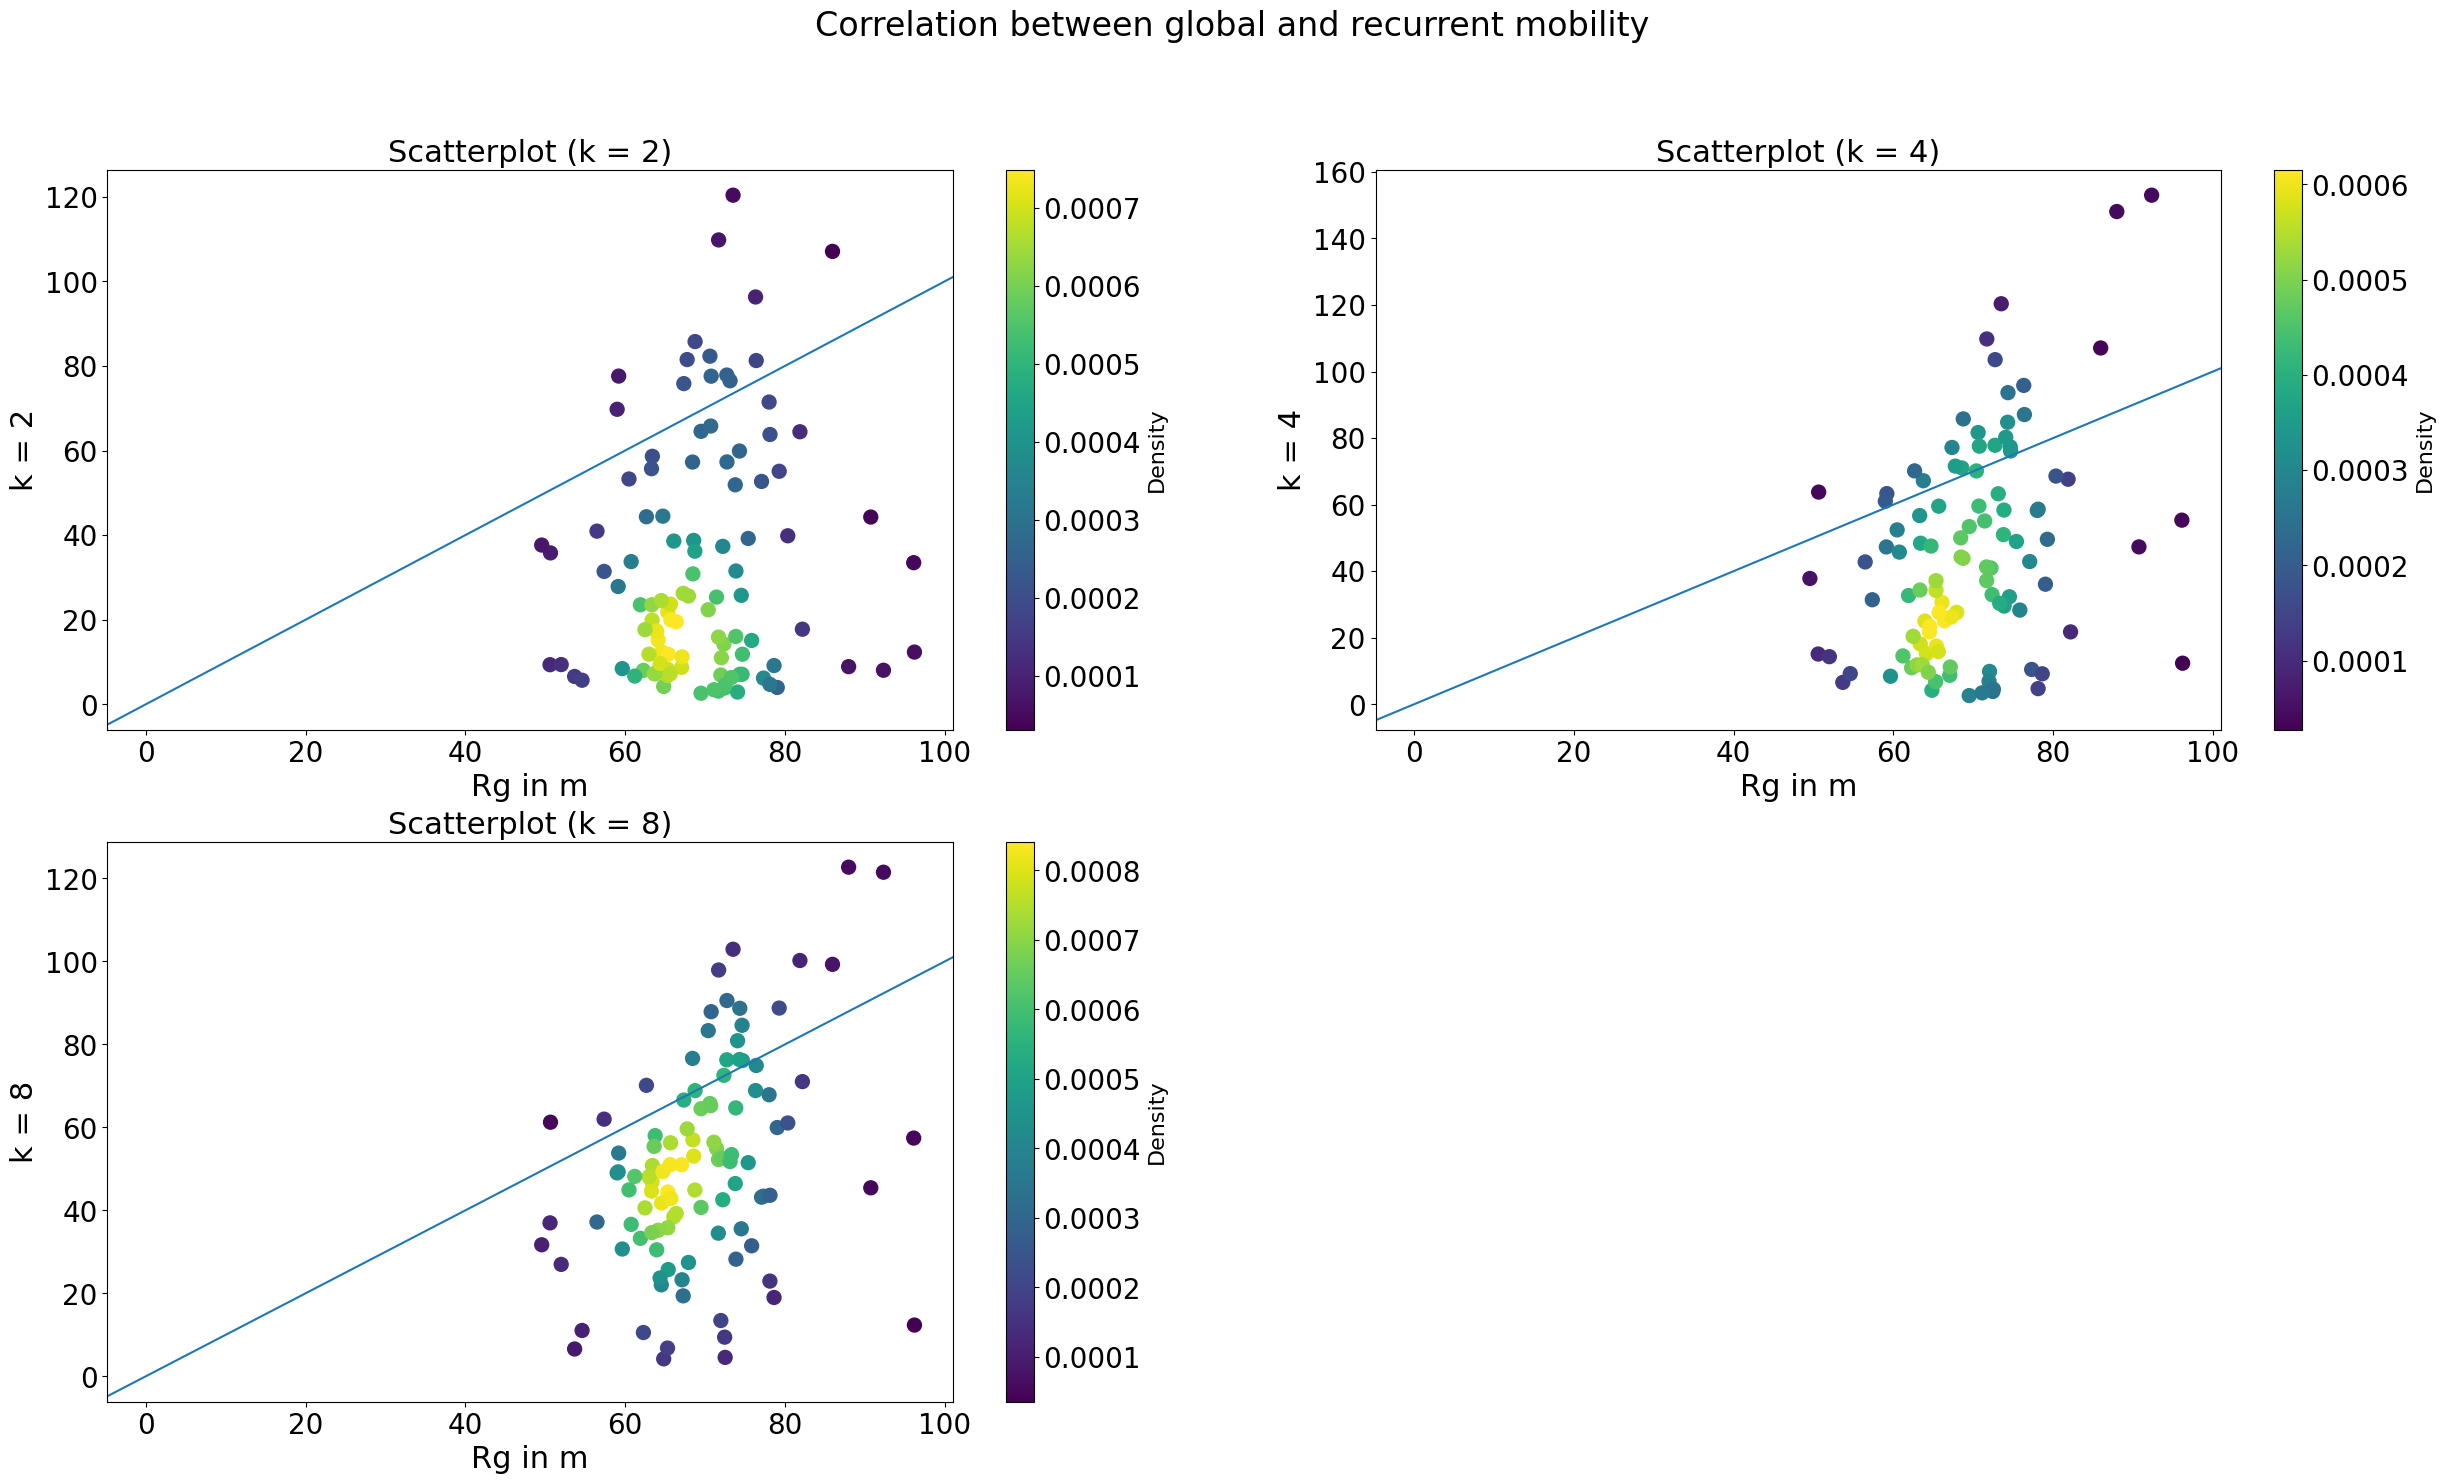

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Check the lengths of the arrays
print(len(second_elements))
print(len(Rg1))

# Create the subplots: 2 rows, 2 columns
fig, axs = plt.subplots(2, 2, figsize=(30, 16))  # 2 rows, 2 columns

# Subplot 1: k = 2
xy = np.vstack([Rg1, second_elements])
z = gaussian_kde(xy)(xy)
hb = axs[0, 0].scatter(Rg1, second_elements, c=z, s=100)
axs[0, 0].set_title('Scatterplot (k = 2)', fontsize=22)  # Increase title font size
axs[0, 0].set_xlabel('Rg in m', fontsize=22)  # Increase axis label font size
axs[0, 0].set_ylabel('k = 2', fontsize=22)  # Increase axis label font size
axs[0, 0].axline((0, 0), slope=1)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
cb = plt.colorbar(hb, ax=axs[0, 0])
cb.set_label('Density', fontsize=16)  # Increase colorbar label size
cb.ax.tick_params(labelsize=20)  # Increase colorbar tick label size

# Subplot 2: k = 4
xy = np.vstack([Rg1, fourth_elements])
z1 = gaussian_kde(xy)(xy)
hb = axs[0, 1].scatter(Rg1, fourth_elements, c=z1, s=100)
axs[0, 1].set_title('Scatterplot (k = 4)', fontsize=22)  # Increase title font size
axs[0, 1].set_xlabel('Rg in m', fontsize=22)  # Increase axis label font size
axs[0, 1].set_ylabel('k = 4', fontsize=22)  # Increase axis label font size
axs[0, 1].axline((0, 0), slope=1)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
cb = plt.colorbar(hb, ax=axs[0, 1])
cb.set_label('Density', fontsize=16)  # Increase colorbar label size
cb.ax.tick_params(labelsize=20)  # Increase colorbar tick label size

# Subplot 3: k = 8 (spanning the entire second row)
xy = np.vstack([Rg1, eight_elements])
z2 = gaussian_kde(xy)(xy)
hb = axs[1, 0].scatter(Rg1, eight_elements, c=z2, s=100)
axs[1, 0].set_title('Scatterplot (k = 8)', fontsize=22)  # Increase title font size
axs[1, 0].set_xlabel('Rg in m', fontsize=22)  # Increase axis label font size
axs[1, 0].set_ylabel('k = 8', fontsize=22)  # Increase axis label font size
axs[1, 0].axline((0, 0), slope=1)
axs[1, 0].tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
cb = plt.colorbar(hb, ax=axs[1, 0])
cb.set_label('Density', fontsize=16)  # Increase colorbar label size
cb.ax.tick_params(labelsize=20)  # Increase colorbar tick label size

# Remove the empty subplot (axs[1, 1])
fig.delaxes(axs[1, 1])

# Overall title for the figure
plt.suptitle('Correlation between global and recurrent mobility', fontsize=24)  # Increase overall title font size

# Display the plots
plt.show()


/tmp/ipykernel_11853/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_11853/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_11853/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_11853/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax

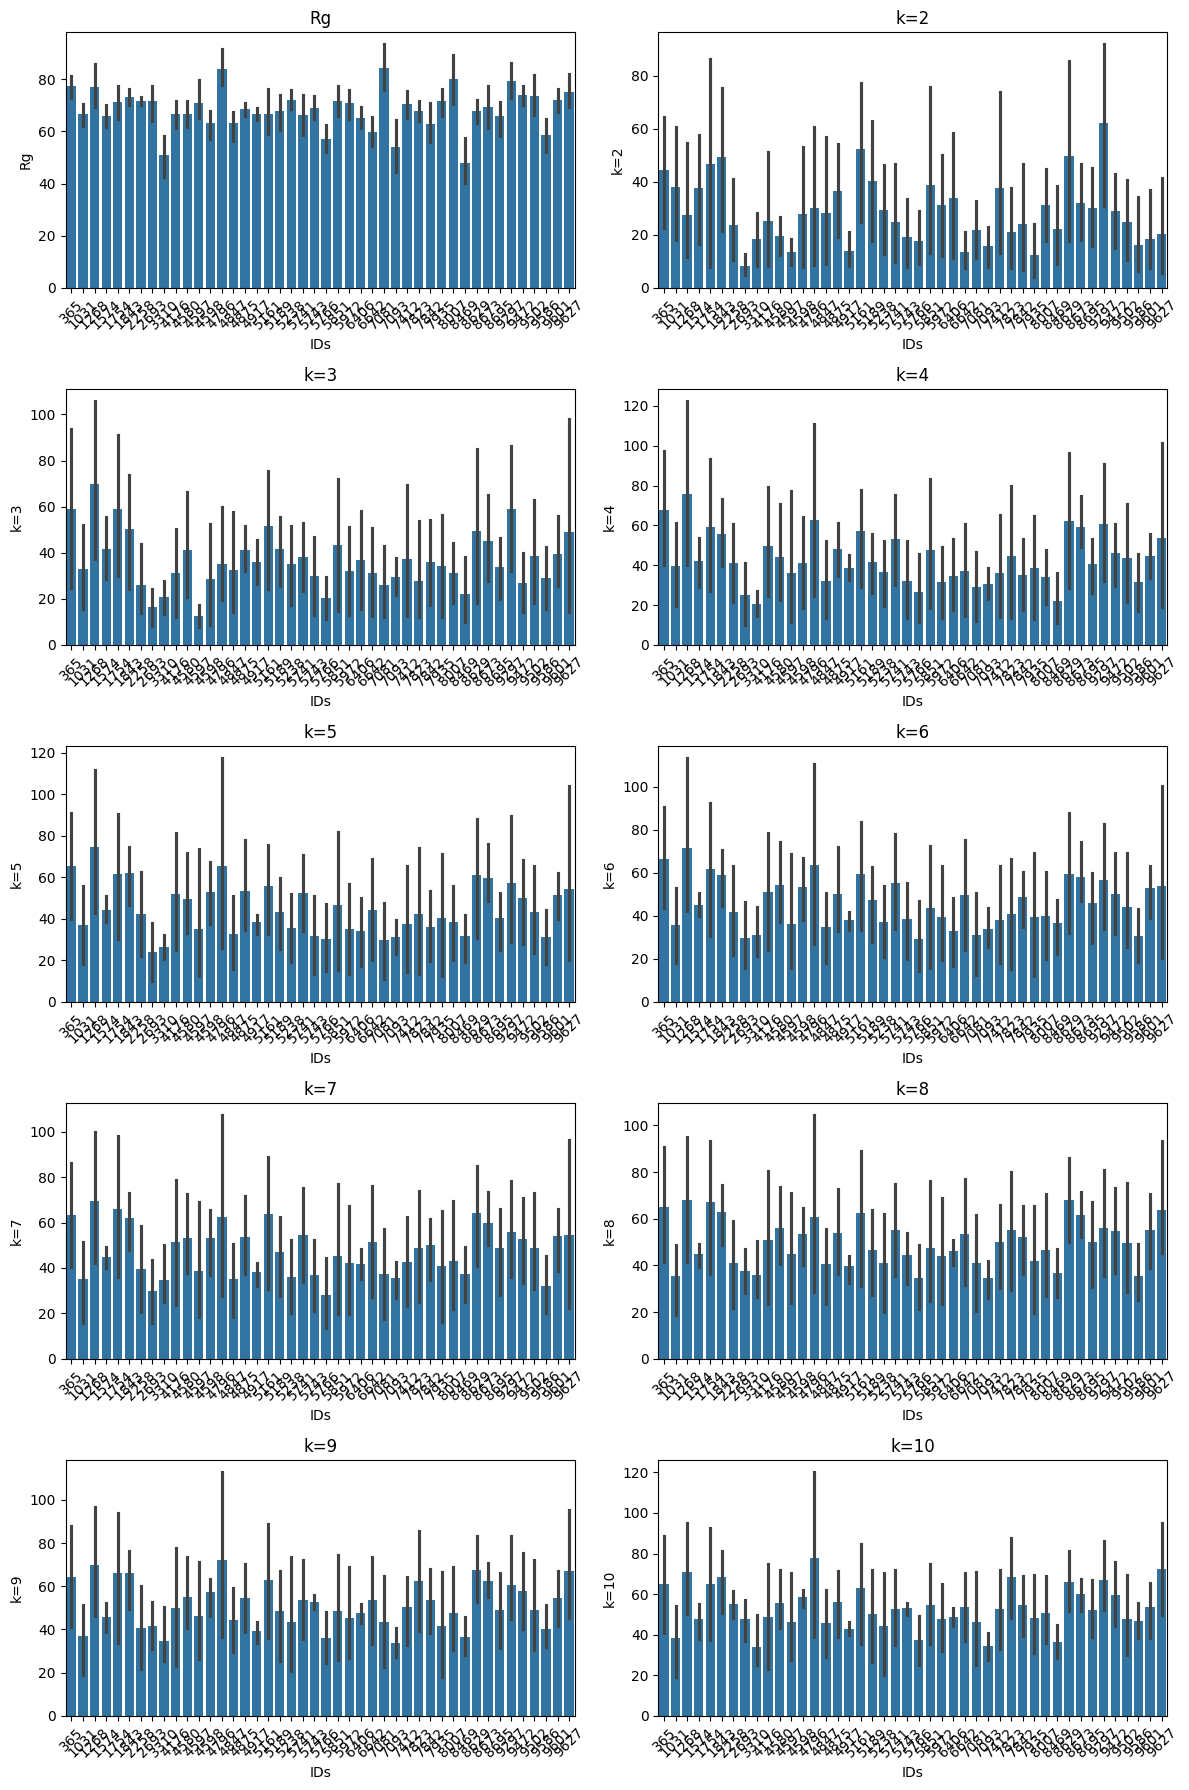

In [25]:
# Create a figure and axis objects
fig, axes = plt.subplots(5, 2, figsize=(12, 18))  # 5 rows, 2 columns for 10 subplots

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate over each column (except the first one if it's an index column)
for i, column in enumerate(df.columns[2:]):
    ax = axes[i]  # Get the current axis
    sns.barplot(x='IDs', y=column, data=df, ax=ax)  # Create the bar plot
    ax.set_title(column)  # Set the title of the subplot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

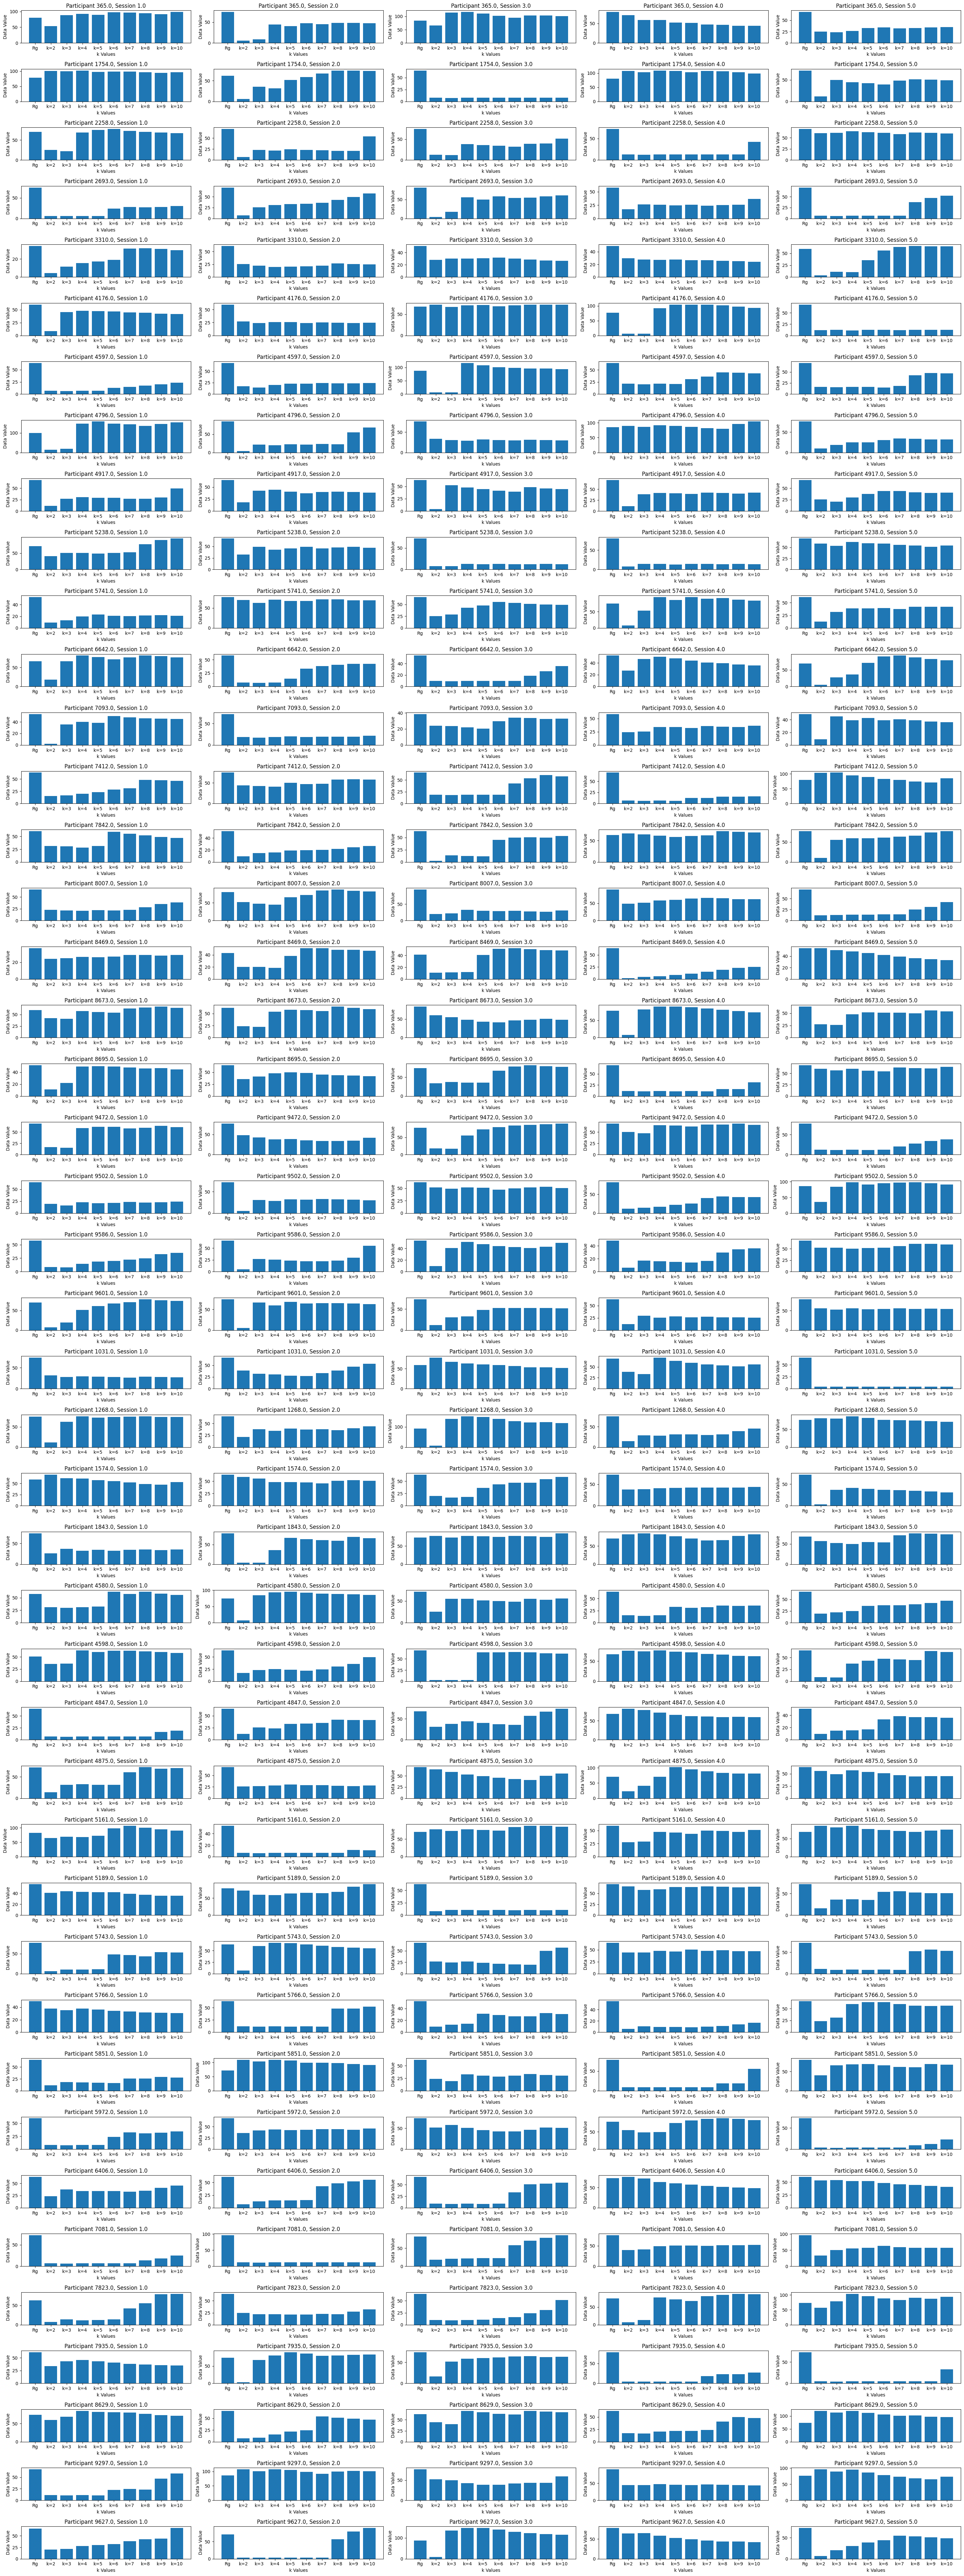

In [26]:
# Drop the 'IDs' column to get only the data values
data = df.drop(['IDs', 'session'], axis=1)

fig, axes = plt.subplots(44, 5, figsize=(30, 80))  # 23 rows, 5 columns for 221 subplots

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

for i, (index, row) in enumerate(df.iterrows()):
    participant_id = row['IDs']
    sessions = row['session']
    participant_data = row.drop(['IDs', 'session'])  # Drop the ID column from the row
    ax = axes[i]
    ax.bar(data.columns, participant_data)
    ax.set_title(f'Participant {participant_id}, Session {sessions}')
    ax.set_xlabel('k Values')
    ax.set_ylabel('Data Value')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [27]:
def bisector_method(df, k):
    # rg(k) > rg/2
    for i, row in df.iterrows(): #iterate over each row
        if row[f'k={k}'] > (row['Rg'] / 2 ): # if rg(k) > rg/2
            returners.append((row['IDs'], row['session'])) # returner
        else:
            explorers.append((row['IDs'], row['session'])) # explorer

for k in range(2, 11):
    returners = []
    explorers = []
    bisector_method(df, k)
    print(f'K = {k}: Numbers returners: {len(returners)}, Numbers of explorers: {len(explorers)}')


K = 2: Numbers returners: 72, Numbers of explorers: 148
K = 3: Numbers returners: 104, Numbers of explorers: 116
K = 4: Numbers returners: 124, Numbers of explorers: 96
K = 5: Numbers returners: 136, Numbers of explorers: 84
K = 6: Numbers returners: 139, Numbers of explorers: 81
K = 7: Numbers returners: 152, Numbers of explorers: 68
K = 8: Numbers returners: 164, Numbers of explorers: 56
K = 9: Numbers returners: 171, Numbers of explorers: 49
K = 10: Numbers returners: 180, Numbers of explorers: 40


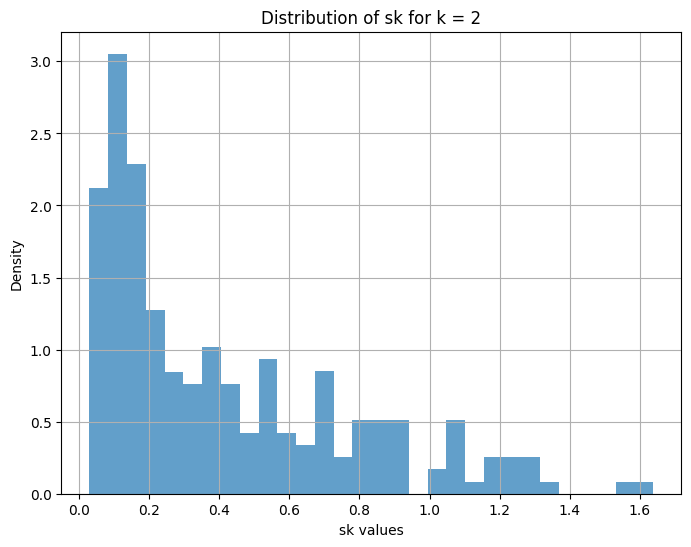

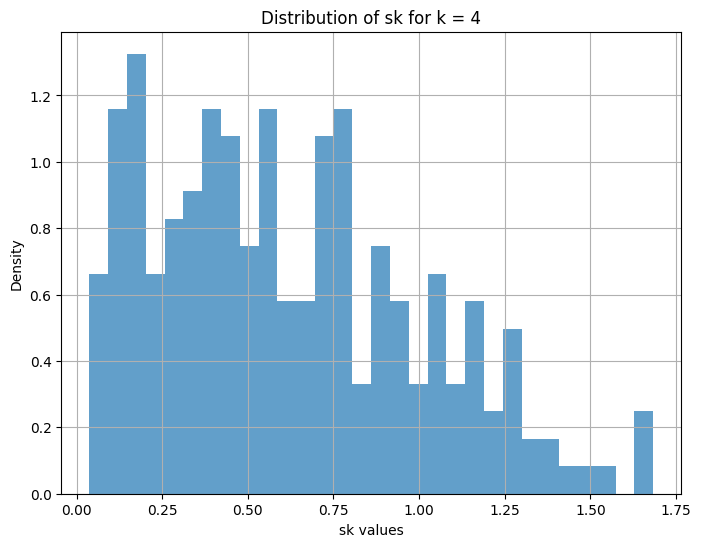

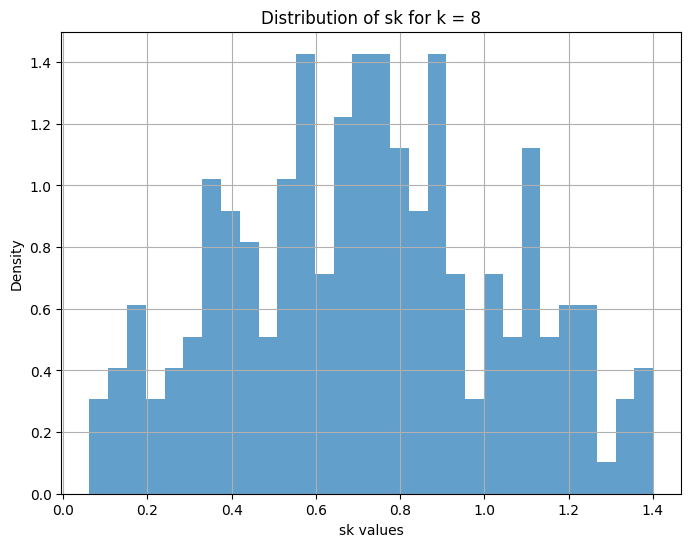

In [28]:
def calculate_sk(df, k):
    skvalues = df[f'k={k}'] / df['Rg']
    return skvalues

def plot_distribution_sk(skvalues, k):
    plt.figure(figsize = (8,6))
    plt.hist(skvalues, bins=30, density=True, alpha=0.7)
    plt.title(f"Distribution of sk for k = {k}")
    plt.xlabel("sk values")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

ks = [2,4,8]

for k in ks:
    sk_values = calculate_sk(df, k)
    plot_distribution_sk(sk_values, k)



In [29]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


In [30]:
df = pd.read_csv('data_both.csv')

# Assuming df has columns 'rg' and 'rg_k'
rg = df['Rg']
rg_k = df['k=2']


In [31]:
# Bisector method classification
df['bisector_class'] = np.where(rg_k > rg / 2, 'k-returner', 'k-explorer')
df.head()

,IDs,session,Rg,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,bisector_class
0,365,1,80.297273,53.628205,88.762678,92.904789,89.516883,98.047397,97.144428,94.299625,92.049609,98.613507,k-returner
1,365,2,74.375489,5.867708,8.849357,44.164456,40.170059,47.490907,44.902567,48.256170,47.890641,47.120747,k-explorer
2,365,3,84.146092,66.093267,114.850203,116.853635,110.942600,102.333746,95.003078,103.997710,103.368727,100.681698,k-returner
3,365,4,79.268485,70.894281,58.926594,58.584021,52.378965,51.347398,47.610275,46.763462,44.248193,43.589460,k-returner
4,365,5,68.329612,25.153838,23.715266,26.760574,33.104108,34.245173,32.445276,32.544736,34.412605,35.076224,k-explorer


In [32]:
len(rg)

220

In [33]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df[['Rg', 'k=2']]
y = df['bisector_class']  # Using bisector method results as initial labels for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) # split the data set into training and testing sets

# Train SVM
svm_classifier = SVC(kernel='linear') # draw a linear hyperplane to split the data
svm_classifier.fit(X_train, y_train) # fit now with testing data set

# Predict using SVM
df['svm_class'] = svm_classifier.predict(X)


In [34]:
# Fit EM clustering algorithm
em = GaussianMixture(n_components=2, random_state=42)
df['em_class'] = em.fit_predict(X)

# Map clusters to 'k-returner' and 'k-explorer' based on means or another criterion
# Here we assume cluster 0 corresponds to 'k-explorer' and 1 to 'k-returner'
df['em_class'] = df['em_class'].map({0: 'k-explorer', 1: 'k-returner'})


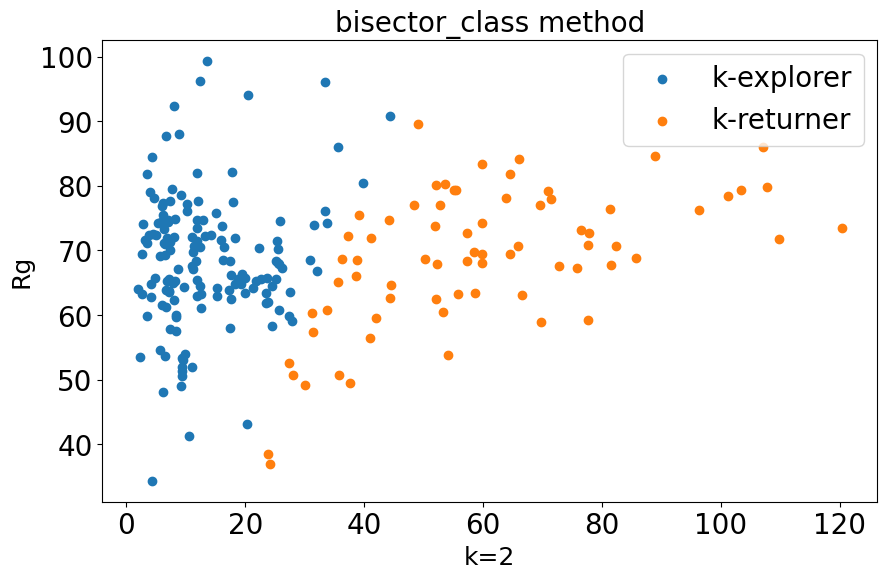

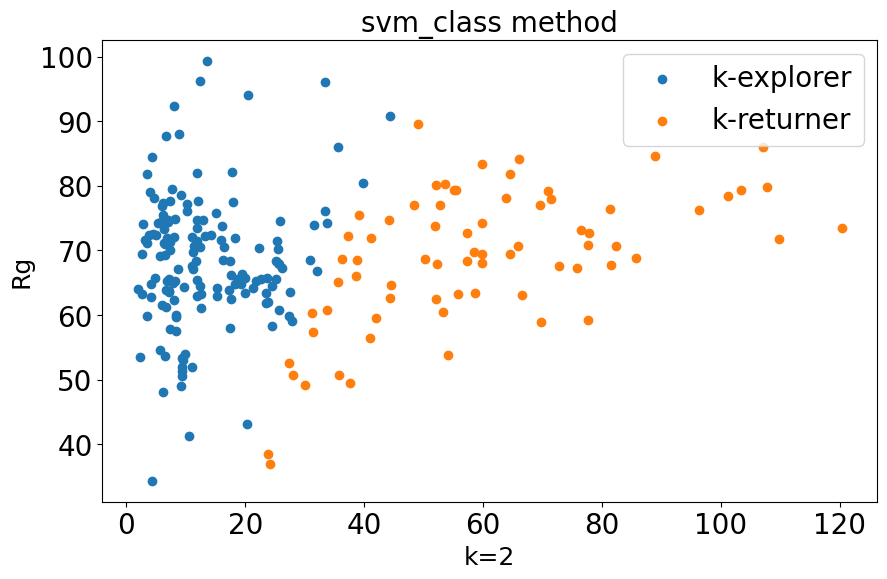

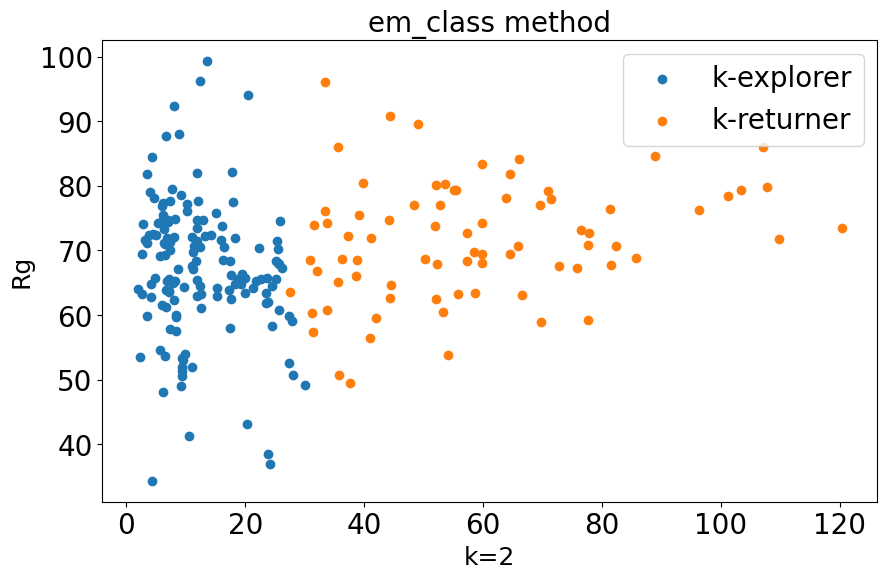

In [35]:
def plot_classification(df, method, x='k=2', y='Rg'):
    plt.figure(figsize=(10, 6))
    groups = df.groupby(method)
    for name, group in groups:
        plt.scatter(group[x], group[y], label=name)
    plt.xlabel(x, fontsize = 18)
    plt.ylabel(y, fontsize = 18)
    plt.title(f'{method} method', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize = 20)
    plt.show()

# Plot results
plot_classification(df, 'bisector_class')
plot_classification(df, 'svm_class')
plot_classification(df, 'em_class')

df.to_csv('data_both.csv')


30
14
29
15


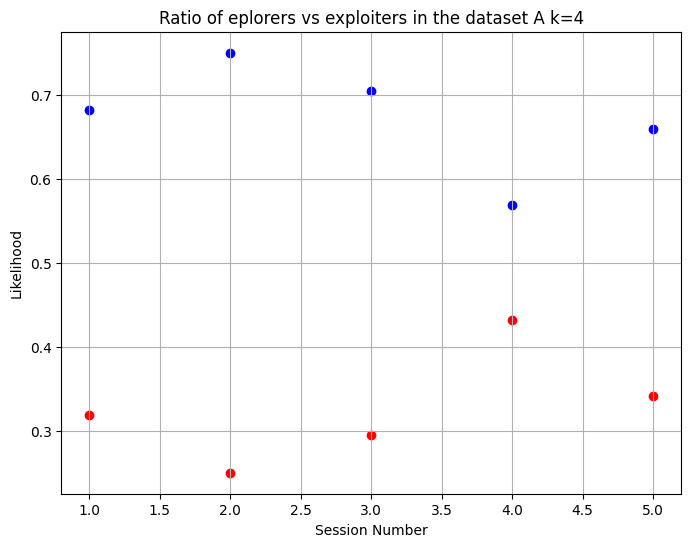

In [36]:
# ratio plot of the exploitative vs explorative mobility patterns
df2 = pd.read_csv('data_both.csv')
rg = df2['k=2']
session = df2['session']
classi = df2['bisector_class']

sess1e = []
sess1r = []
sess2e = []
sess2r = []
sess3e = []
sess3r = []
sess4e = []
sess4r = []
sess5e = []
sess5r = []

# get the rg values for every session, seperated in lists for session
for i in range(0, len(rg)):
    if session[i] == 1:
        if classi[i] == 'k-explorer':
            sess1e.append(classi[i])
        else:
            sess1r.append(classi[i])
    if session[i] == 2:
        if classi[i] == 'k-explorer':
            sess2e.append(classi[i])
        else:
            sess2r.append(classi[i])
    if session[i] == 3:
        if classi[i] == 'k-explorer':
            sess3e.append(classi[i])
        else:
            sess3r.append(classi[i])
    if session[i] == 4:
        if classi[i] == 'k-explorer':
            sess4e.append(classi[i])
        else:
            sess4r.append(classi[i])
    if session[i] == 5:
        if classi[i] == 'k-explorer':
            sess5e.append(classi[i])
        else:
            sess5r.append(classi[i])



print(len(sess1e))
print(len(sess1r))
print(len(sess5e))
print(len(sess5r))

prope = []
prope.append(len(sess1e)/(len(sess1e) + len(sess1r)))
prope.append(len(sess2e)/(len(sess2e) + len(sess2r)))
prope.append(len(sess3e)/(len(sess3e) + len(sess3r)))
prope.append(len(sess4e)/(len(sess4e) + len(sess4r)))
prope.append(len(sess5e)/(len(sess5e) + len(sess5r)))

propr = []
for i in prope:
    propr.append(1-i)

plt.figure(figsize=(8, 6))
plt.scatter([1,2,3,4,5], prope, color='blue', alpha=1)
plt.scatter([1,2,3,4,5], propr, color='red', alpha=1)
plt.title('Ratio of eplorers vs exploiters in the dataset A k=4')
plt.xlabel('Session Number')
plt.ylabel('Likelihood')
plt.grid(True)
plt.show() 
    



K = 2: Numbers of returners: 72, Numbers of explorers: 148
K = 3: Numbers of returners: 104, Numbers of explorers: 116
K = 4: Numbers of returners: 124, Numbers of explorers: 96
K = 5: Numbers of returners: 136, Numbers of explorers: 84
K = 6: Numbers of returners: 139, Numbers of explorers: 81
K = 7: Numbers of returners: 152, Numbers of explorers: 68
K = 8: Numbers of returners: 164, Numbers of explorers: 56
K = 9: Numbers of returners: 171, Numbers of explorers: 49
K = 10: Numbers of returners: 180, Numbers of explorers: 40


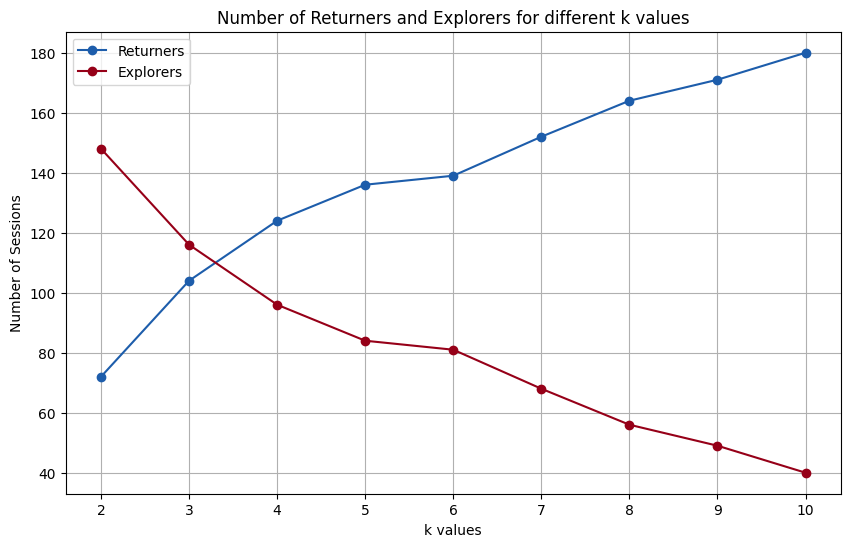

In [37]:
#classification plot 

def bisector_method(df, k):
    returners = []
    explorers = []
    for i, row in df.iterrows():  # iterate over each row
        if row[f'k={k}'] > (row['Rg'] / 2):  # if rg(k) > rg/2
            returners.append((row['IDs'], row['session']))  # returner
        else:
            explorers.append((row['IDs'], row['session']))  # explorer
    return len(returners), len(explorers)

k_values = range(2, 11)
num_returners = []
num_explorers = []

for k in k_values:
    returners_count, explorers_count = bisector_method(df, k)
    num_returners.append(returners_count)
    num_explorers.append(explorers_count)
    print(f'K = {k}: Numbers of returners: {returners_count}, Numbers of explorers: {explorers_count}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, num_returners, label='Returners', marker='o', color = '#1d5dabff')
plt.plot(k_values, num_explorers, label='Explorers', marker='o', color = '#960018')
plt.xlabel('k values')
plt.ylabel('Number of Sessions')
plt.title('Number of Returners and Explorers for different k values')
plt.legend()
plt.grid(True)
plt.show()

#1d5dabff","#8a3409ff", "#ccbe61ff



In [38]:
connection.close()